# Simple_Moving_Average_Analysis
**Author**: Hansen Han  
**Date**: February 4th, 2023  

#### Load Libraries

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import pandas as pd
from tqdm import trange # for tracking progress


#### Load Data

In [1]:
# Load 1 min BTC data from 2013 to 2019

# handle minute data from 2014 to 2019
df2019 = pd.read_csv("BTC_1min_bitfinex/2019.txt", header=None)
df2018 = pd.read_csv("BTC_1min_bitfinex/2018.txt", header=None)
df2017 = pd.read_csv("BTC_1min_bitfinex/2017.txt", header=None)
df2016 = pd.read_csv("BTC_1min_bitfinex/2016.txt", header=None)
df2015 = pd.read_csv("BTC_1min_bitfinex/2015.txt", header=None)
df2014 = pd.read_csv("BTC_1min_bitfinex/2014.txt", header=None)

# handle hourly data from 2018 to 2023
df2018_2023 = pd.read_csv("BTC_1min_bitfinex/2018_2023.csv", skiprows=[0])
df2018_2023['volume'] = df2018_2023['Volume USD']
df2018_2023['timestamp'] = df2018_2023['date']
df2018_2023.drop(['unix', 'symbol', 'Volume BTC', 'Volume USD', 'date'], axis=1, inplace=True)
df2018_2023

# removed 2013 data
#df2013 = pd.read_csv("BTC_1min_bitfinex/2013.txt", header=None)
#frames = [df2013, df2014, df2015, df2016, df2017, df2018, df2019]

frames = [df2014, df2015, df2016, df2017, df2018, df2019]

crypto_df = pd.concat(frames)
crypto_df.rename(columns = {0: 'timestamp', 1: 'open', 2: 'close', 3: 'high', 4: 'low', 5: 'volume'}, inplace=True)

# Convert UTC timestamp to readable 
from datetime import datetime
crypto_df['timestamp'] = [datetime.utcfromtimestamp(int(ts)/1000).strftime('%Y-%m-%d %H:%M:%S') for ts in crypto_df['timestamp']]

def merge_and_convert_to_hourly(minute_data, hourly_data):
    # Convert timestamp column to datetime format
    minute_data['timestamp'] = pd.to_datetime(minute_data['timestamp'], format='%Y-%m-%d %H:%M:%S')
    hourly_data['timestamp'] = pd.to_datetime(hourly_data['timestamp'], format='%Y-%m-%d %H:%M:%S')

    # Filter minute_data to only include data from 2014 to 2018
    minute_data = minute_data[minute_data['timestamp'].dt.year < 2019]

    # Round minute_data timestamp to nearest hour
    minute_data['timestamp'] = minute_data['timestamp'].dt.floor('H')

    # Find the latest timestamp in minute_data
    latest_minute_timestamp = minute_data['timestamp'].max()

    # Filter hourly_data to only include data from after the latest timestamp in minute_data
    hourly_data = hourly_data[hourly_data['timestamp'] > latest_minute_timestamp]

    # Combine the two dataframes
    combined_data = pd.concat([minute_data, hourly_data])

    # Drop any duplicates
    combined_data = combined_data.drop_duplicates(subset='timestamp', keep='last')

    # Sort by timestamp
    combined_data = combined_data.sort_values('timestamp')

    # Set the timestamp column as the index
    combined_data = combined_data.set_index('timestamp')

    # Resample to hourly data
    combined_data = combined_data.resample('H').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })

    # Reset the index
    combined_data = combined_data.reset_index()

    return combined_data


crypto_df = merge_and_convert_to_hourly(crypto_df, df2018_2023)
crypto_df


/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


timestamp        open        high         low       close  \
0     2014-01-01 00:00:00    739.2800    739.2800    739.2800    739.2800   
1     2014-01-01 01:00:00    742.9989    742.9989    742.9989    742.9989   
2     2014-01-01 02:00:00    748.4900    748.8900    748.4900    748.8900   
3     2014-01-01 03:00:00    740.0000    743.1000    740.0000    740.0000   
4     2014-01-01 04:00:00    745.3100    745.3100    745.3100    745.3100   
...                   ...         ...         ...         ...         ...   
80036 2023-02-17 20:00:00  24523.0000  25023.0000  24523.0000  24834.0000   
80037 2023-02-17 21:00:00  24833.0000  24841.0000  24426.0000  24495.0000   
80038 2023-02-17 22:00:00  24479.0000  24745.0000  24057.0000  24692.0000   
80039 2023-02-17 23:00:00  24687.0000  24745.0000  24525.0000  24582.0000   
80040 2023-02-18 00:00:00  24580.0000  24790.0000  24553.0000  24655.0000   

             volume  
0      1.500000e-01  
1      3.720000e+00  
2      5.740000e+00  
3      2.256364e+00  
4      1.745600e+00  
...             ...  
80036  1.012941e+07  
80037  4.186570e+06  
80038  5.983257e+06  
80039  1.484912e+06  
80040  3.599322e+05  

[80041 rows x 6 columns]

In [2]:
# add quarters to the data

# Make sure the 'Datetime' column is in datetime format
crypto_df['Datetime'] = pd.to_datetime(crypto_df['timestamp'])

# Calculate the start date and year of the first entry
start_date = crypto_df['Datetime'].min()
start_year = start_date.year

# Create a function to calculate the quarter
def calculate_quarter(row):
    months_passed = (row['Datetime'].year - start_year) * 12 + row['Datetime'].month - start_date.month
    return (months_passed // 3) + 1

# Apply the function to create the 'quarter' column
crypto_df['quarter'] = crypto_df.apply(calculate_quarter, axis=1)

# make sure the quarter assignments look right...
crypto_df

timestamp        open        high         low       close  \
0     2014-01-01 00:00:00    739.2800    739.2800    739.2800    739.2800   
1     2014-01-01 01:00:00    742.9989    742.9989    742.9989    742.9989   
2     2014-01-01 02:00:00    748.4900    748.8900    748.4900    748.8900   
3     2014-01-01 03:00:00    740.0000    743.1000    740.0000    740.0000   
4     2014-01-01 04:00:00    745.3100    745.3100    745.3100    745.3100   
...                   ...         ...         ...         ...         ...   
80036 2023-02-17 20:00:00  24523.0000  25023.0000  24523.0000  24834.0000   
80037 2023-02-17 21:00:00  24833.0000  24841.0000  24426.0000  24495.0000   
80038 2023-02-17 22:00:00  24479.0000  24745.0000  24057.0000  24692.0000   
80039 2023-02-17 23:00:00  24687.0000  24745.0000  24525.0000  24582.0000   
80040 2023-02-18 00:00:00  24580.0000  24790.0000  24553.0000  24655.0000   

             volume            Datetime  quarter  
0      1.500000e-01 2014-01-01 00:00:00        1  
1      3.720000e+00 2014-01-01 01:00:00        1  
2      5.740000e+00 2014-01-01 02:00:00        1  
3      2.256364e+00 2014-01-01 03:00:00        1  
4      1.745600e+00 2014-01-01 04:00:00        1  
...             ...                 ...      ...  
80036  1.012941e+07 2023-02-17 20:00:00       37  
80037  4.186570e+06 2023-02-17 21:00:00       37  
80038  5.983257e+06 2023-02-17 22:00:00       37  
80039  1.484912e+06 2023-02-17 23:00:00       37  
80040  3.599322e+05 2023-02-18 00:00:00       37  

[80041 rows x 8 columns]

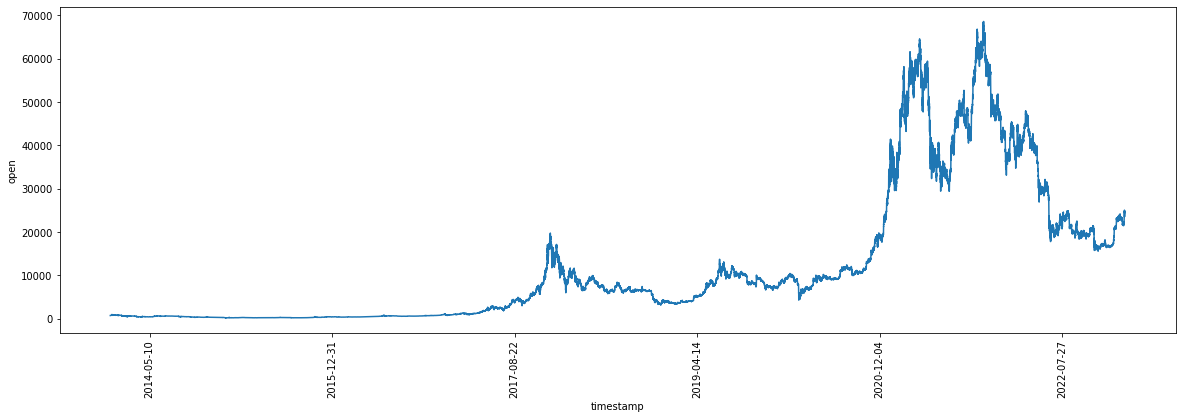

In [3]:
# View the data to make sure it looks right 
warnings.filterwarnings('ignore')
#plt.style.use('dark_background')

#sns.set_context("talk")
plt.figure(figsize=(20,6))
ax = sns.lineplot(x="timestamp", y="open", 
            data=crypto_df, ci=None)
ax.xaxis.set_major_locator(ticker.MaxNLocator(7))
plt.xticks(rotation="vertical")

plt.show() # looks right...

#### Simple Moving Average (SMA) Crossover Strategy Backtesting

In [5]:
import numpy as np

def sma_crossover_backtester(sampled_data, 
                            order_sizing, 
                            ma1_length, 
                            ma2_length, 
                            starting_capital,
                            display_results,
                            shorting_allowed,
                            fixed_fee,
                            record_balance,
                            show_moving_averages,
                            annual_taxes,
                            tax_percentage = 0,
                            fee=0
                            ):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma1_length: moving average 1 length (in hours)
        ma2_length: moving average 2 length (in hours, must be longer than ma1_length)
        starting_capital: how much capital to start with (USD)
        display_results: plot the portfolio value over time (true or false)
        shorting_allowed: whether or not to short or sell regularly (true or false)
        fixed_fee: whether to use volume based fee or a fixed fee (true or false)
        fee: if fixed fee, the % charged per transaction by the exchange (0.01 = 1%), default = 0
        record_balance: whether or not to track the balance over the whole period
        show_moving_averages: whether or not to show the moving averages in the plot displayed (true or false)
        annual_taxes: whether or not to take annual taxes on gains (true or false)
        tax_percentage: if taxes are enabled, what % of taxes to pay on gains (0.01 = 1%), default = 0
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """

    # for figuring out how much a fee is
    # we are taking the average of maker and taker fees on coinbase pro starting on 6/5/23
    def find_fee(thirty_day_volume):
        volume_fee_table = {
            10000: 0.005,
            50000: 0.00325,
            100000: 0.002,
            1000000: 0.0015,
            15000000: 0.0013,
            75000000: 0.0011,
            250000000: 0.00075,
            400000000: 0.0004,
        }
        
        for volume, fee in volume_fee_table.items():
            if thirty_day_volume <= volume:
                return fee
        
        # If the volume is greater than the largest key, return the fee for the largest key
        return volume_fee_table[400000000]

    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if ma2_length < ma1_length:
        return "Could not run ma_crossover_backtester(), ma1_length is larger than ma2_length."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    # calculate the total number of quarters in the dataset
    total_quarters = max(list(sampled_data['quarter']))
    # total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    # total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # # calculate quarter intervals
    # quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    # monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # # convert to get the corresponding timestamps
    # quarter_intervals = [sampled_data.iloc[x]['timestamp'] for x in quarter_intervals]
    # monthly_intervals = [sampled_data.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma1 = sampled_data.price.rolling(ma1_length).mean()
    ma2 = sampled_data.price.rolling(ma2_length).mean()

    #truncate the data so they all are aligned 
    ma1 = list(ma1[ma2_length:])
    ma2 = list(ma2[ma2_length:])
    sampled_data = sampled_data[ma2_length:]
    last_average_higher = "None"

    # set up shorting mechanism
    short_position = None
    short_results = []

    # set up volume data
    thirty_day_volume = 0
    volume_data = []

    # set up tax information, when the year changes, we check if we gained or lost for the year, and then put that aside for taxes
    sampled_data['timestamp'] = pd.to_datetime(sampled_data['timestamp'])

    past_year = sampled_data.iloc[0]['timestamp'].year
    annual_change = 0
    past_quarter = 1
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        # calculate the fee using the thirty_day_volume
        if not fixed_fee:
            fee = find_fee(thirty_day_volume)

        #get the current price
        current_price = sampled_data.iloc[x]['price']
        current_quarter = sampled_data.iloc[x]['quarter']

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital

            annual_baseline_balance = starting_capital

        # if the year has changed, calculate how much has happened
        if annual_taxes == True:
            current_year = sampled_data.iloc[x]['timestamp'].year
            if current_year != past_year:
                # the year has changed
                if short_position == True:
                    short_delta = (purchase_price*position_size - current_price*position_size)
                    current_balance = (purchase_price*position_size + short_delta + fiat)
                else:
                    current_balance = current_price*position_size + fiat

                annual_change = current_balance - annual_baseline_balance

                # if we had a gain that year, you need to pay taxes
                if annual_change > 0:
                    taxes_due = annual_change*tax_percentage
                    
                    # if currently holding a position, will need to sell some of it to make up for the taxes...(since fiat is probably low)
                    if position_size != 0:
                        taxes_due = annual_change*tax_percentage - fiat #use all fiat first
                        amount_to_sell = taxes_due/current_price # find out how many shares will cover the amount due
                        position_size = position_size - amount_to_sell # reduce that many shares from the amount due
                    else:
                        fiat = fiat - taxes_due
                
                # reset the new amount
                annual_baseline_balance = position_size*current_price + fiat
            
            past_year = current_year
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        # if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
        #     monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
        #     monthly_return_rates.append(monthly_return_rate)
        #     monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if current_quarter != past_quarter:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size
        
        past_quarter = current_quarter
            
        #keep track of which one was higher previously
        if ma1[x] > ma2[x]:
            current_average_higher = "MA1"
        elif ma1[x] < ma2[x]:
            current_average_higher = "MA2"
        else:
            current_average_higher = "None"

        if x == 0:
            pass
            #moves.append("Pass")
        else:
            #begin the trading mechanism

            #if the shorter average crosses over the longer average - BUY
            if current_average_higher == "MA1" and last_average_higher == "MA2":
                if shorting_allowed == True:
                    if short_position == True:
                        # if there is a short position, exit out of it
                        short_delta = (purchase_price*position_size - current_price*position_size) # calculate the delta for the short
                        short_results.append(short_delta)
                        fiat = fiat + (purchase_price*position_size + short_delta)*(1 - fee) # sell the position and the short
                        position_size = 0 # set the position to zero
                    
                    short_position = False


                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat*(1 - fee))/current_price #add the btc purchased
                
                # record the volume information (the amount purchased)
                volume_data.append([
                    0,(order_sizing*fiat*(1 - fee))/current_price
                ])

                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                #moves.append("Buy")
                trades = trades + 1
                purchase_price = current_price

                

            #if the shorter average goes under the longer average - SELL
            elif current_average_higher == "MA2" and last_average_higher == "MA1":
                fiat = fiat + position_size*current_price*(1 - fee)
                position_size = 0

                # record the volume information (the amount sold)
                volume_data.append([
                    0,position_size*current_price*(1 - fee)
                ])

                if shorting_allowed == True:
                    position_size = (order_sizing*fiat*(1 - fee))/current_price
                    fiat = fiat - position_size*current_price
                    short_position = True
                    purchase_price = current_price
                    #moves.append("Short-Sell")
                else:
                    pass
                    purchase_price = 0
                    #moves.append("Sell")

                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                

            else:
                pass
                #moves.append("Pass")

        if shorting_allowed == True:
            #record the portfolio information
            if short_position == False or short_position == None:
                if record_balance == True:
                    portfolio_balance.append(position_size*current_price + fiat)
            if short_position == True:
                short_delta = (purchase_price*position_size - current_price*position_size)
                if record_balance == True:
                    portfolio_balance.append(purchase_price*position_size + short_delta + fiat)
        else:
            #record the portfolio information
            if record_balance == True:
                portfolio_balance.append(position_size*current_price + fiat)
            
        if record_balance == True:
            baseline_balance.append(baseline_position_size*current_price)
        
        #record which moving average was higher this moment
        last_average_higher = current_average_higher

        # go through the volume data
        thirty_day_volume = 0 # re-calculate the current thirty_day_volume
        new_volume_data = []
        for volume_data_entry in volume_data:
            if volume_data_entry[0] < 720: # 720 hours in thirty days
                thirty_day_volume = thirty_day_volume + volume_data_entry[1]
                new_volume_data.append([volume_data_entry[0] + 1, volume_data_entry[1]])
        
        volume_data = new_volume_data

    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1    
    final_return_rate = ((position_size*current_price + fiat)/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    #sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))
    sharpe_ratio = None

    if display_results == True and record_balance == True:
        plot_data = pd.DataFrame()
        plot_data['time'] = sampled_data['timestamp']
        plot_data['Baseline'] = baseline_balance
        plot_data['SMA Crossover'] = portfolio_balance
        if show_moving_averages:
            plot_data["MA1"] = [i*baseline_position_size for i in ma1]
            plot_data["MA2"] = [i*baseline_position_size for i in ma2]
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()
    else:
        plot_data = "Could not generate plot_data: display_results and/or record_balance was set to False."

    # calculate quarters_beating_baseline
    count = 0
    for x in range(0, len(quarter_return_rates)):
        # we round so that a difference of 0.0000000001, etc. won't bring it over the edge.
        if round(quarter_return_rates[x],2) > round(baseline_return_rates[x],2):
            count = count + 1
    
    quarters_beating_baseline = round(count/len(quarter_return_rates), 2)

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio,
               "quarters_beating_baseline": quarters_beating_baseline,
               "strategy_quarterly_stdev": statistics.stdev(quarter_return_rates),
               "baseline_quarterly_stdev": statistics.stdev(baseline_return_rates)

    }
    
    return backtest_results


def plot_quarterly_data(backtest_results):
    '''
    Visualize quarterly data from a backtest run.

    Parameters:
        backtest_results: dict generated by sma_crossover_backtester()
    Returns:
        None
    '''

    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    quarterly_data = pd.DataFrame()
    quarterly_data['quarter'] = [x + 1 for x in range(0, len(backtest_results["quarter_return_rates"]))]
    quarterly_data['return'] = [x*100 for x in backtest_results["quarter_return_rates"]]
    quarterly_data['trades'] = backtest_results["quarter_trades"]
    quarterly_data['hit_rate'] = backtest_results["quarter_hit_rates"]
    quarterly_data['baseline'] = [x*100 for x in backtest_results["baseline_return_rates"]]

    # Hit Rate
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="hit_rate",data=quarterly_data,palette=clrs)
    #Drawing a horizontal line at 0.5
    graph.axhline(0.5)
    plt.show()

    # Returns
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="return",data=quarterly_data,palette=clrs)
    plt.show()

    # Number of trades
    graph = sns.barplot(x="quarter",y="trades",data=quarterly_data,palette=clrs)
    plt.show()

    # Comparing quarterly returns
    comparison_df = pd.DataFrame()
    comparison_df['Return (%)']  = list(quarterly_data['return']) + list(quarterly_data['baseline'])
    comparison_df['Quarter'] = [x for x in quarterly_data['quarter']] + [x for x in quarterly_data['quarter']]
    comparison_df['Strategy'] = ["SMA Crossover" for x in quarterly_data['quarter']] + ["Buy and Hold" for x in quarterly_data['quarter']]

    sns.barplot(data=comparison_df, x='Quarter', y='Return (%)', hue='Strategy')
    plt.show()

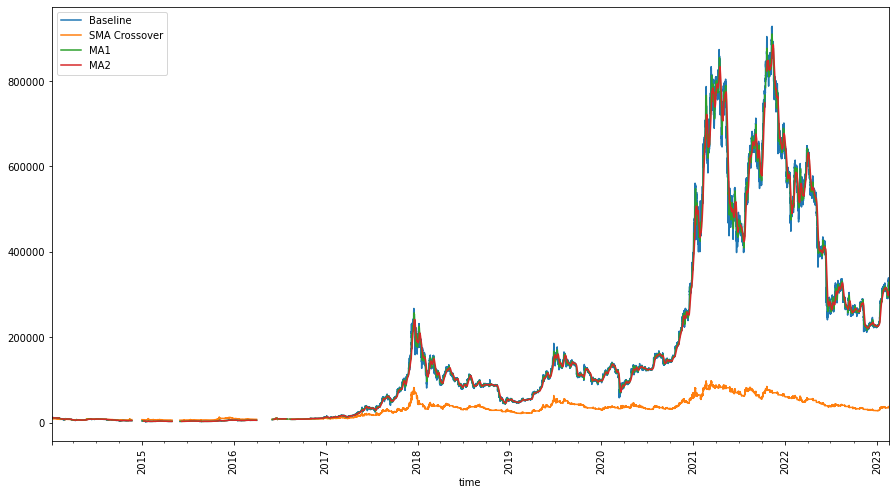

Hit Rate: 1.0
SMA Crossover Return Rate: 271.85 %
Buy & Hold Return Rate: 3224.86 %
Median Return per Quarter: -0.02 %


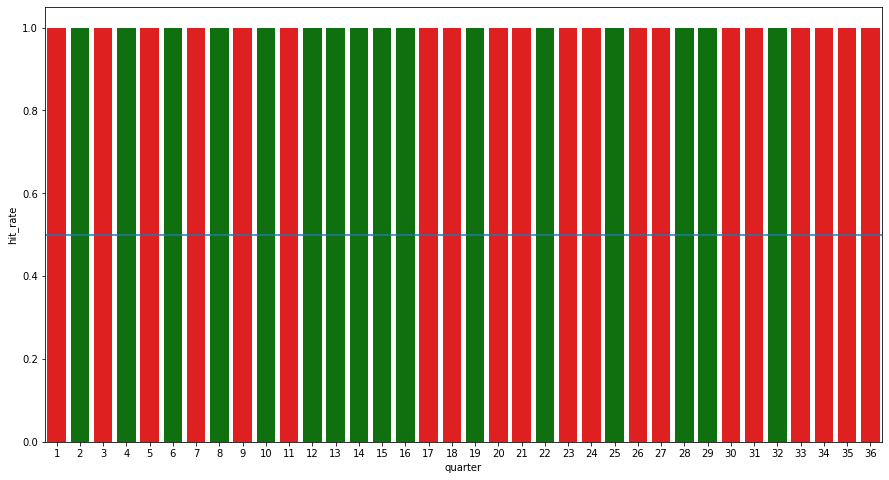

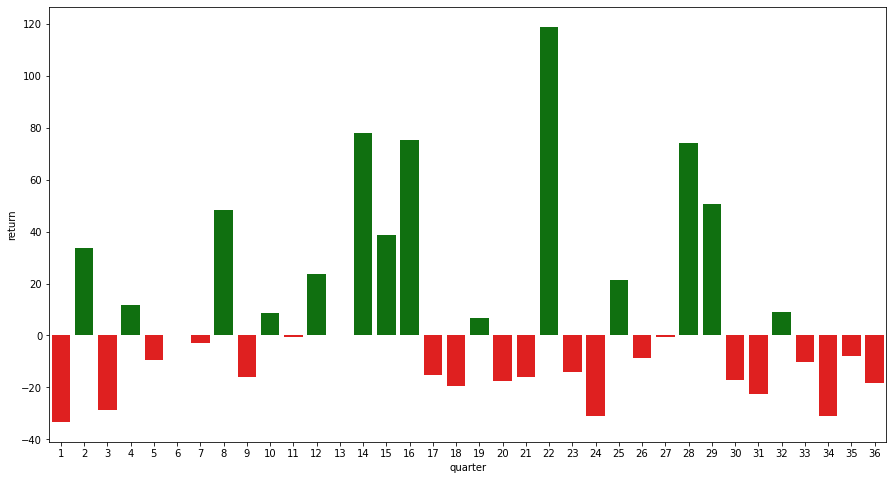

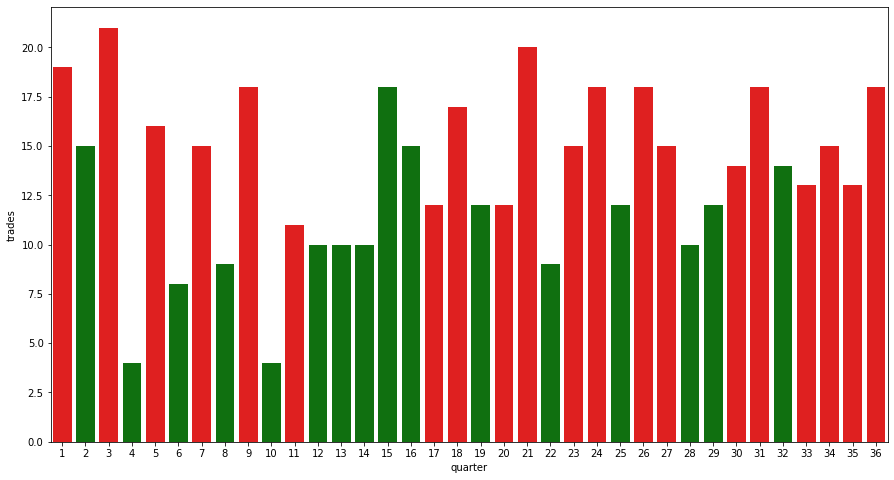

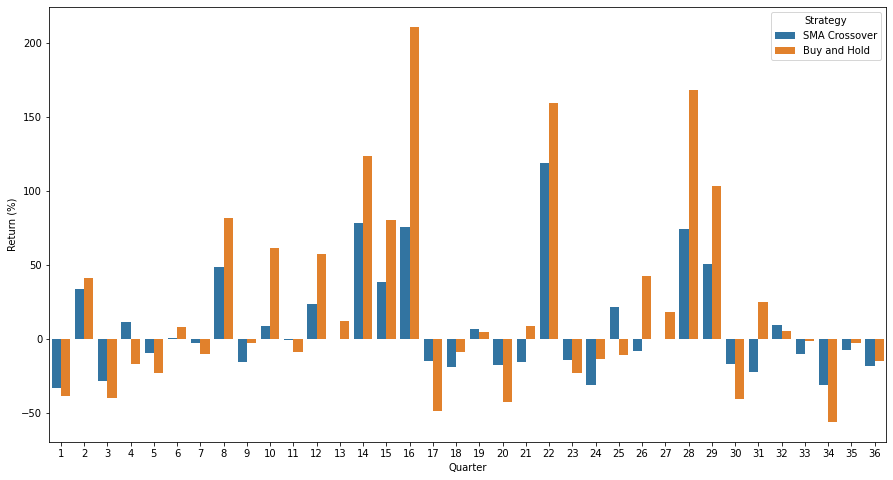

In [7]:
# Run the crossover backtester on the whole dataset 
crypto_df['price'] = crypto_df['open'] # set open to be the price to use 

backtest_results = sma_crossover_backtester(
            sampled_data = crypto_df,
            order_sizing = 1,
            ma1_length = 48, 
            ma2_length = 168, 
            starting_capital = 10000,
            display_results=True,
            shorting_allowed=False,
            fixed_fee = False,
            record_balance = True,
            show_moving_averages = True,
            annual_taxes = True,
            tax_percentage = 0.3,
            fee = 0.5
        )

# Interpret backtest results
import statistics
#print("Sharpe Ratio:", round(backtest_results['sharpe_ratio'],2))
print("Hit Rate:", backtest_results['hit_rate'])
print("SMA Crossover Return Rate:", round(backtest_results['final_return_rate']*100,2), "%")
print("Buy & Hold Return Rate:", round(backtest_results['baseline_return_rate']*100,2), "%")
print("Median Return per Quarter:", round(statistics.median(backtest_results['quarter_return_rates']*100), 2), "%")

plot_quarterly_data(backtest_results)

### What are the optimal parameters for SMA crossover strategy? 

In [20]:
from concurrent.futures import ProcessPoolExecutor

def random_ma_length_generator():
    """
    Generate random moving averages for optimization purposes.
    """
    import random
    num1 = random.randrange(0, round(2191/2))
    num2 = random.randrange(0, round(2191/2))
    while num2 < num1:
        num2 = random.randrange(0, round(2191/2))
    
    return num1, num2

def run_single_backtest(x, crypto_df, shorting_allowed, fixed_fee):
    ma1_length, ma2_length = random_ma_length_generator()

    backtest_results = sma_crossover_backtester(
        sampled_data=crypto_df,
        order_sizing=1,
        ma1_length=ma1_length,
        ma2_length=ma2_length,
        starting_capital=10000,
        display_results=False,
        shorting_allowed=shorting_allowed,
        fixed_fee=fixed_fee,
        record_balance=True,
        show_moving_averages=False,
        annual_taxes=True,
        tax_percentage=0.3,
        fee=0
    )
    
    # Extract and return relevant results
    return (ma1_length, ma2_length, backtest_results)

def run_multiple_backtests(shorting_allowed, num_runs, fixed_fee, crypto_df):

    with ProcessPoolExecutor() as executor:
        results = list(executor.map(run_single_backtest, range(num_runs), [crypto_df] * num_runs, [shorting_allowed] * num_runs, [fixed_fee] * num_runs))
    
    
    # compile results into a table for exploration
    
    result_dict = {
        "ma1_length": [],
        "ma2_length": [],
        "cumulative_return": [],
        "cumulative_baseline_return": [],
        "profitable_quarters": [],
        "total_trades": [],
        "quarters_beating_baseline_results": [],
        "strategy_quarterly_stdev": [],
        "baseline_quarterly_stdev": []
    }


    for res in results:
        ma1_length, ma2_length, backtest_results = res

        result_dict['ma1_length'].append(ma1_length)
        result_dict['ma2_length'].append(ma2_length)
        result_dict['cumulative_return'].append(backtest_results['final_return_rate'])
        result_dict['cumulative_baseline_return'].append(backtest_results['baseline_return_rate'])
        result_dict['profitable_quarters'].append(len([x for x in backtest_results['quarter_return_rates'] if x > 0]))
        result_dict['total_trades'].append(sum([x for x in backtest_results['quarter_trades']]))
        result_dict['quarters_beating_baseline_results'].append(backtest_results['quarters_beating_baseline'])
        result_dict['strategy_quarterly_stdev'].append(backtest_results['strategy_quarterly_stdev'])
        result_dict['baseline_quarterly_stdev'].append(backtest_results['baseline_quarterly_stdev'])


    optimization_results = pd.DataFrame(result_dict)

    
    
    return optimization_results

In [22]:
result_df = run_multiple_backtests(
    shorting_allowed = False,
    num_runs = 100,
    fixed_fee = False,
    crypto_df = crypto_df
)

result_df
# much faster!

ma1_length  ma2_length  cumulative_return  cumulative_baseline_return  \
0          393         733          16.102713                   32.248566   
1          599         981          13.501647                   32.248566   
2          956         998           6.802271                   32.248566   
3          467        1031          10.144268                   32.248566   
4          805         914          13.169904                   32.248566   
..         ...         ...                ...                         ...   
95         653         991          12.687034                   32.248566   
96         563         731          13.773082                   32.248566   
97         470         999          12.548606                   32.248566   
98          49         131          -0.137479                   32.248566   
99         391         751          16.585301                   32.248566   

    profitable_quarters  total_trades  quarters_beating_baseline_results  \
0                    16            97                               0.39   
1                    12            69                               0.36   
2                    15           136                               0.31   
3                    11            59                               0.31   
4                    14           103                               0.33   
..                  ...           ...                                ...   
95                   14            69                               0.39   
96                   14           112                               0.31   
97                   12            65                               0.33   
98                   15           620                               0.31   
99                   13            92                               0.33   

    strategy_quarterly_stdev  baseline_quarterly_stdev  
0                   0.447609                  0.643615  
1                   0.433306                  0.643615  
2                   0.380017                  0.643615  
3                   0.441763                  0.643615  
4                   0.413569                  0.643615  
..                       ...                       ...  
95                  0.426794                  0.643615  
96                  0.445639                  0.643615  
97                  0.443621                  0.643615  
98                  0.357616                  0.643615  
99                  0.443002                  0.643615  

[100 rows x 9 columns]

In [26]:
# look for
result_df[result_df.quarters_beating_baseline_results == max(result_df.quarters_beating_baseline_results)]

ma1_length  ma2_length  cumulative_return  cumulative_baseline_return  \
24          97         319           9.697162                   32.248566   
76         646         741          12.606473                   32.248566   
84         636         674           9.862619                   32.248566   

    profitable_quarters  total_trades  quarters_beating_baseline_results  \
24                   16           242                               0.44   
76                   15           135                               0.44   
84                   13           211                               0.44   

    strategy_quarterly_stdev  baseline_quarterly_stdev  
24                  0.408564                  0.643615  
76                  0.437563                  0.643615  
84                  0.443095                  0.643615

In [27]:
result_shorting_df = run_multiple_backtests(
    shorting_allowed = True,
    num_runs = 100,
    fixed_fee = False,
    crypto_df = crypto_df
)

result_shorting_df

ma1_length  ma2_length  cumulative_return  cumulative_baseline_return  \
0          729         745          -0.466861                   32.248566   
1          352         858          26.789149                   32.248566   
2          152         487           4.065166                   32.248566   
3          206        1010          39.369995                   32.248566   
4          828         832          -0.126300                   32.248566   
..         ...         ...                ...                         ...   
95         581         682           5.593672                   32.248566   
96         355         825          14.735440                   32.248566   
97         368         829          13.640836                   32.248566   
98         629         693           3.501711                   32.248566   
99         161         437           0.890168                   32.248566   

    profitable_quarters  total_trades  quarters_beating_baseline_results  \
0                    18           268                               0.28   
1                    23            75                               0.33   
2                    22           146                               0.36   
3                    21            58                               0.25   
4                    17           459                               0.31   
..                  ...           ...                                ...   
95                   17           136                               0.39   
96                   22            78                               0.31   
97                   22            79                               0.31   
98                   16           161                               0.39   
99                   17           159                               0.39   

    strategy_quarterly_stdev  baseline_quarterly_stdev  
0                   0.510279                  0.643615  
1                   0.459060                  0.643615  
2                   0.485691                  0.643615  
3                   0.552508                  0.643615  
4                   0.475265                  0.643615  
..                       ...                       ...  
95                  0.488013                  0.643615  
96                  0.456745                  0.643615  
97                  0.463197                  0.643615  
98                  0.497265                  0.643615  
99                  0.485788                  0.643615  

[100 rows x 9 columns]

In [29]:
# what is the highest performing strategy?
result_shorting_df[result_shorting_df.cumulative_return == max(result_shorting_df.cumulative_return)]

ma1_length  ma2_length  cumulative_return  cumulative_baseline_return  \
21         375         973          47.168996                   32.248566   

    profitable_quarters  total_trades  quarters_beating_baseline_results  \
21                   21            64                               0.31   

    strategy_quarterly_stdev  baseline_quarterly_stdev  
21                  0.531873                  0.643615

In [33]:
# are there any strategies that consistently beat buy and hold?
result_shorting_df[result_shorting_df.quarters_beating_baseline_results > 0.5]

Empty DataFrame
Columns: [ma1_length, ma2_length, cumulative_return, cumulative_baseline_return, profitable_quarters, total_trades, quarters_beating_baseline_results, strategy_quarterly_stdev, baseline_quarterly_stdev]
Index: []

In [35]:
# look for strategies that have lower standard deivation and higher returns
result_shorting_df[result_shorting_df.strategy_quarterly_stdev < result_shorting_df.baseline_quarterly_stdev][result_shorting_df.cumulative_return > result_shorting_df.cumulative_baseline_return]

ma1_length  ma2_length  cumulative_return  cumulative_baseline_return  \
3          206        1010          39.369995                   32.248566   
21         375         973          47.168996                   32.248566   
39         252        1069          37.717707                   32.248566   
76         345         944          38.355311                   32.248566   

    profitable_quarters  total_trades  quarters_beating_baseline_results  \
3                    21            58                               0.25   
21                   21            64                               0.31   
39                   19            58                               0.25   
76                   21            68                               0.31   

    strategy_quarterly_stdev  baseline_quarterly_stdev  
3                   0.552508                  0.643615  
21                  0.531873                  0.643615  
39                  0.568679                  0.643615  
76                  0.513252                  0.643615

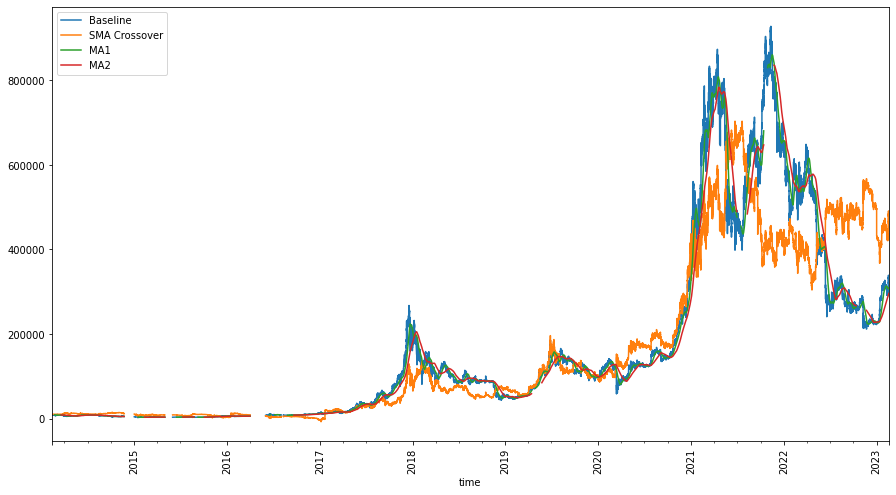

In [30]:
backtest_results = sma_crossover_backtester(
        sampled_data=crypto_df,
        order_sizing=1,
        ma1_length=375,
        ma2_length=973,
        starting_capital=10000,
        display_results=True,
        shorting_allowed=True,
        fixed_fee=False,
        record_balance=True,
        show_moving_averages=True,
        annual_taxes=True,
        tax_percentage=0.3,
        fee=0
    )

In [ ]:
# Run all the combinations we want to look at 
combo_1_results = run_multiple_backtests(shorting_allowed=True, num_runs=100, fixed_fee=True)
combo_1_results.to_csv("run_output/sma_crossover_shorting_no_fee_{todays_date}.csv".format(todays_date=end_date))

combo_2_results = run_multiple_backtests(shorting_allowed=True, num_runs=100, fixed_fee=False)
combo_2_results.to_csv("run_output/sma_crossover_shorting_with_fee_{todays_date}.csv".format(todays_date=end_date))

combo_3_results = run_multiple_backtests(shorting_allowed=False, num_runs=100, fixed_fee=True)
combo_3_results.to_csv("run_output/sma_crossover_no_shorting_no_fee_{todays_date}.csv".format(todays_date=end_date))

combo_4_results = run_multiple_backtests(shorting_allowed=False, num_runs=100, fixed_fee=False)
combo_4_results.to_csv("run_output/sma_crossover_no_shorting_with_fee_{todays_date}.csv".format(todays_date=end_date))